## Setup

In [1]:
from IPython import get_ipython # type: ignore
ipython = get_ipython(); assert ipython is not None
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

# Standard imports
import os
import torch
import numpy as np
from tqdm import tqdm
import plotly.express as px
import pandas as pd
import einops
from jaxtyping import Float, Int
from torch import Tensor

torch.set_grad_enabled(False)

# Device setup
GPU_TO_USE = 1

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = f"cuda:{GPU_TO_USE}" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

# utility to clear variables out of the memory & and clearing cuda cache
import gc
def clear_cache():
    gc.collect()
    torch.cuda.empty_cache()

Device: cuda:1


In [2]:
from pathlib import Path
import sys
import os

def get_base_folder(project_root = "tim-taras-sfc-errors"):
	# Find the project root dynamically
	current_dir = os.getcwd()
	while True:
		if os.path.basename(current_dir) == project_root:  # Adjust to match your project root folder name
			break
		parent = os.path.dirname(current_dir)
		if parent == current_dir:  # Stop if we reach the system root (failsafe)
			raise RuntimeError(f"Project root {project_root} not found. Check your folder structure.")
		current_dir = parent

	return current_dir

def get_project_folder(base_folder=None, project_folder_name='sfc-errors'):
	if base_folder is None:
		base_folder = get_base_folder()
	
	return Path(base_folder) / project_folder_name

def get_data_path(base_folder=None, data_folder_name='data'):
	if base_folder is None:
		base_folder = get_base_folder()

	return Path(base_folder) / data_folder_name

In [3]:
base_path = get_base_folder()
print(f"Base path: {base_path}")

project_path = get_project_folder(base_folder=base_path)
print(f"Project path: {project_path}")

sys.path.append(base_path)
sys.path.append(str(project_path))

Base path: /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors
Project path: /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/sfc-errors


In [4]:
datapath = get_data_path(base_path) 
datapath

PosixPath('/mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/data')

## Loading the model

We'll work with Gemma-2 2B (base version)

In [5]:
from sae_lens import SAE, HookedSAETransformer, ActivationsStore

USE_INSTRUCT = False
PARAMS_COUNT = 2

MODEL_NAME = f'gemma-2-{PARAMS_COUNT}b' + ('-it' if USE_INSTRUCT else '')
print(f'Using {MODEL_NAME}')

model = HookedSAETransformer.from_pretrained(MODEL_NAME, device=device, dtype=torch.bfloat16)
model

Using gemma-2-2b


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b into HookedTransformer


HookedSAETransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-25): 26 x TransformerBlock(
      (ln1): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln1_post): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2_post): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
      

## Loading the data

This uses my custom dataloader class, which parses raw data and prepares into a nice format for SFC, including providing some useful metadata such as token positions for where the answer should be, attention masks etc. The details of the class are convoluted because it was developed for a more general purpose than verb agreement tasks, so you can largely ignore the next few cells.

In [6]:
from classes.sfc_data_loader import SFCDatasetLoader
import utils.prompts as prompts
from utils.enums import *

In [7]:
DATASET_NAME = SupportedDatasets.VERB_AGREEMENT

dataloader = SFCDatasetLoader(DATASET_NAME, model,
                              local_dataset=True, base_folder_path=datapath)

In [8]:
clean_dataset, corrupted_dataset = dataloader.get_clean_corrupted_datasets(tokenize=True, apply_chat_template=False, prepend_generation_prefix=True)

Figuring out optimal padding length...
Filtered out 484 longest prompts from a total of 10560 prompts.
Setting max prompt length to 8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10076/10076 [00:15<00:00, 651.75it/s]


- Corrupted dataset here refers to the collection of patched prompts and their answers (verb completions) in the SFC paper terminology.
- The datasets support padding but currently its logic doesn't work well with templatic datasets like this, gotta fix it later **TODO**

In [9]:
CONTROL_SEQ_LEN = clean_dataset['control_sequence_length'][0].item() # how many first tokens to ignore when computing SFC scores
N_CONTEXT = clean_dataset['prompt'].shape[1]

CONTROL_SEQ_LEN, N_CONTEXT

(2, 8)

In [10]:
print('Clean dataset:')
for prompt in clean_dataset['prompt'][:3]:
  print("\nPrompt:", model.to_string(prompt), end='\n\n')

  for i, tok in enumerate(prompt):
    str_token = model.to_string(tok)
    print(f"({i-CONTROL_SEQ_LEN}, {str_token})", end=' ')
  print()

print('Corrupted dataset:')
for prompt in corrupted_dataset['prompt'][:3]:
  print("\nPrompt:", model.to_string(prompt), end='\n\n')
  
  for i, tok in enumerate(prompt):
    str_token = model.to_string(tok)
    print(f"({i-CONTROL_SEQ_LEN}, {str_token})", end=' ')
  print()

Clean dataset:

Prompt: <bos>The doctors that the executives like<pad>

(-2, <bos>) (-1, The) (0,  doctors) (1,  that) (2,  the) (3,  executives) (4,  like) (5, <pad>) 

Prompt: <bos>The fathers that the driver visits<pad>

(-2, <bos>) (-1, The) (0,  fathers) (1,  that) (2,  the) (3,  driver) (4,  visits) (5, <pad>) 

Prompt: <bos>The boys that the parents inform<pad>

(-2, <bos>) (-1, The) (0,  boys) (1,  that) (2,  the) (3,  parents) (4,  inform) (5, <pad>) 
Corrupted dataset:

Prompt: <bos>The doctor that the executives like<pad>

(-2, <bos>) (-1, The) (0,  doctor) (1,  that) (2,  the) (3,  executives) (4,  like) (5, <pad>) 

Prompt: <bos>The father that the driver visits<pad>

(-2, <bos>) (-1, The) (0,  father) (1,  that) (2,  the) (3,  driver) (4,  visits) (5, <pad>) 

Prompt: <bos>The boy that the parents inform<pad>

(-2, <bos>) (-1, The) (0,  boy) (1,  that) (2,  the) (3,  parents) (4,  inform) (5, <pad>) 


In [11]:
# Sanity checks

# Control sequence length must be the same for all samples in both datasets
clean_ds_control_len = clean_dataset['control_sequence_length']
corrupted_ds_control_len = corrupted_dataset['control_sequence_length']

assert torch.all(corrupted_ds_control_len == corrupted_ds_control_len[0]), "Control sequence length is not the same for all samples in the dataset"
assert torch.all(clean_ds_control_len == clean_ds_control_len[0]), "Control sequence length is not the same for all samples in the dataset"
assert clean_ds_control_len[0] == corrupted_ds_control_len[0], "Control sequence length is not the same for clean and corrupted samples in the dataset"
assert clean_dataset['answer'].max().item() < model.cfg.d_vocab, "Clean answers exceed vocab size"
assert corrupted_dataset['answer'].max().item() < model.cfg.d_vocab, "Patched answers exceed vocab size"
assert (clean_dataset['answer_pos'] < N_CONTEXT).all().item(), "Answer positions exceed logits length"
assert (corrupted_dataset['answer_pos'] < N_CONTEXT).all().item(), "Answer positions exceed logits length"

# Setting up the SAEs

In [13]:
from classes.sfc_model import *

RUN_WITH_SAES = True # we'll run the model with attached SAEs to automatically compute error scores and patch w.r.t. them

# So there will be no caching device (everything we'll be done on a single GPU)
if RUN_WITH_SAES:
    caching_device = device 
else:
    caching_device = "cuda:2"


caching_device

'cuda:1'

I'll use my custom `SFC_Gemma` class. In short, it
- Loads a Gemma model and its Gemma Scope SAEs (either attaching them to the model or not)
- Provides interface methods for computing SFC scores **and activation patching** scores

In [14]:
clear_cache()

sfc_model = SFC_Gemma(model, params_count=PARAMS_COUNT, control_seq_len=CONTROL_SEQ_LEN, 
                      attach_saes=RUN_WITH_SAES, caching_device=caching_device)
sfc_model.print_saes()

clear_cache()

# sfc_model.model.cfg
# , sfc_model.saes[0].cfg.dtype

Using 16K SAEs for the first 26 layers, the rest 0 layer(s) - 131k SAEs
Number of SAEs: 78
blocks.0.hook_resid_post SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)
blocks.1.hook_resid_post SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)
blocks.2.hook_resid_post SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)
blocks.3.hook_resid_post SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_s

# Collecting data for SFC error nodes analysis

We'll compute the following data:

- Activation Difference Norms - `activation_diff_norm`: How much the error node activations change (in magnitude) between clean and patched inputs
- Gradient Norms - `gradient_norm`: The magnitude of the gradient for each error node
- Attribution patching Scores - `atp_score`: The original attribution patching scores (dot product of gradient and activation difference)

In [15]:
batch_size = 64
total_batches = None

# Reset the hooks to avoid weird bugs
sfc_model.model.reset_hooks()
if RUN_WITH_SAES:
    sfc_model._reset_sae_hooks()
clear_cache()

# Compute the our error metrics for each type of error (resid, mlp, attn)
error_metrics = sfc_model.compute_activation_analysis(clean_dataset, corrupted_dataset, 
													  batch_size=batch_size, total_batches=total_batches,
                                                      activation_types=['sae_error'])

error_metrics.keys()

  0%|          | 0/158 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
def process_error_metrics(error_metrics, n_layers=sfc_model.n_layers, max_seq_len=N_CONTEXT):
    """
    Processes the error_metrics dictionary returned by compute_error_node_analysis
    and organizes it into three separate dictionaries for:
    1. Activation difference norms
    2. Gradient norms
    3. Attribution patching scores
    
    Each dictionary has keys for different error node types (resid, mlp, attn)
    and values are 2D tensors organized by layer and position.
    
    Args:
        error_metrics (dict): Dictionary returned by compute_error_node_analysis
    
    Returns:
        tuple: Three dictionaries (activation_diff_norms, gradient_norms, atp_scores)
              each with keys 'resid', 'mlp', 'attn' and tensor values of shape [n_layers, seq_len]
    """

    # Initialize output dictionaries
    activation_diff_norms = {'resid': [], 'mlp': [], 'attn': []}
    gradient_norms = {'resid': [], 'mlp': [], 'attn': []}
    atp_scores = {'resid': [], 'mlp': [], 'attn': []}
    
    # Create tensors for each error type with shape [n_layers, seq_len]
    for error_type in ['resid', 'mlp', 'attn']:
        # Initialize tensors with NaNs
        activation_diff_norms[error_type] = torch.full((n_layers, max_seq_len), float('nan'), device=device)
        gradient_norms[error_type] = torch.full((n_layers, max_seq_len), float('nan'), device=device)
        atp_scores[error_type] = torch.full((n_layers, max_seq_len), float('nan'), device=device)
    
    # Fill in the tensors with actual values
    for key, (act_diff_norm, grad_norm, atp_score) in error_metrics.items():
        parts = key.split('.')
        if len(parts) < 4 or parts[0] != 'blocks':
            continue
        
        layer_num = int(parts[1])
        
        if 'hook_resid_post.hook_sae_error' in key:
            error_type = 'resid'
        elif 'hook_mlp_out.hook_sae_error' in key:
            error_type = 'mlp'
        elif 'attn.hook_z.hook_sae_error' in key:
            error_type = 'attn'
        else:
            continue
        
        activation_diff_norms[error_type][layer_num, :] = act_diff_norm
        gradient_norms[error_type][layer_num, :] = grad_norm
        atp_scores[error_type][layer_num, :] = atp_score
    
    return activation_diff_norms, gradient_norms, atp_scores

In [16]:
activation_diff_norms, gradient_norms, atp_scores = process_error_metrics(error_metrics)

In [17]:
activation_diff_norms['resid'].shape, gradient_norms['mlp'].shape, atp_scores['attn'].shape

(torch.Size([26, 8]), torch.Size([26, 8]), torch.Size([26, 8]))

In [14]:
def save_activation_metrics(activation_diff_norms, gradient_norms, atp_scores, 
                            activation_type='error', dataset_name='sva'):
    """
    Save metrics for a specific activation type (error or resid)
    
    Args:
        activation_diff_norms: Tensor containing activation difference norms
        gradient_norms: Tensor containing gradient norms
        atp_scores: Tensor containing attribution patching scores
        activation_type: String indicating the type of activation ('error' or 'resid')
        dataset_name: Name of the dataset used (default: 'sva')
    """
    metrics = {
        'activation_diff': activation_diff_norms,
        'gradient': gradient_norms,
        'atp_score': atp_scores
    }
    
    for metric_name, metric_data in metrics.items():
        filename = f'{dataset_name}_{activation_type}_{metric_name}.pkl'
        filepath = datapath / filename
        
        print(f'Saving {filename}...')
        torch.save(metric_data, filepath)
    
    print(f'All {activation_type} metrics saved to {datapath}')

In [ ]:
save_activation_metrics(activation_diff_norms, gradient_norms, atp_scores)

Saving sva_error_activation_diff.pkl...
Saving sva_error_gradient.pkl...
Saving sva_error_atp_score.pkl...
All error metrics saved to /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/sfc-errors/data


#### Collecting the same data for resid_post activations

We'll do this to better understand the error nodes metrics we compute above, see the "Results analysis" section

In [15]:
batch_size = 64
total_batches = None

# Reset the hooks to avoid weird bugs
sfc_model.model.reset_hooks()
if RUN_WITH_SAES:
    sfc_model._reset_sae_hooks()
clear_cache()

resid_metrics = sfc_model.compute_activation_analysis(clean_dataset, corrupted_dataset, 
													  batch_size=batch_size, total_batches=total_batches,
                                                      activation_types=['resid_post'])

resid_metrics.keys()

  0%|          | 0/158 [00:00<?, ?it/s]

dict_keys(['blocks.0.hook_resid_post.hook_sae_input', 'blocks.1.hook_resid_post.hook_sae_input', 'blocks.2.hook_resid_post.hook_sae_input', 'blocks.3.hook_resid_post.hook_sae_input', 'blocks.4.hook_resid_post.hook_sae_input', 'blocks.5.hook_resid_post.hook_sae_input', 'blocks.6.hook_resid_post.hook_sae_input', 'blocks.7.hook_resid_post.hook_sae_input', 'blocks.8.hook_resid_post.hook_sae_input', 'blocks.9.hook_resid_post.hook_sae_input', 'blocks.10.hook_resid_post.hook_sae_input', 'blocks.11.hook_resid_post.hook_sae_input', 'blocks.12.hook_resid_post.hook_sae_input', 'blocks.13.hook_resid_post.hook_sae_input', 'blocks.14.hook_resid_post.hook_sae_input', 'blocks.15.hook_resid_post.hook_sae_input', 'blocks.16.hook_resid_post.hook_sae_input', 'blocks.17.hook_resid_post.hook_sae_input', 'blocks.18.hook_resid_post.hook_sae_input', 'blocks.19.hook_resid_post.hook_sae_input', 'blocks.20.hook_resid_post.hook_sae_input', 'blocks.21.hook_resid_post.hook_sae_input', 'blocks.22.hook_resid_post.hook

In [16]:
def process_resid_metrics(resid_metrics):
    n_layers = sfc_model.n_layers
    seq_len = next(iter(resid_metrics.values()))[0].shape[0]
    
    activation_diff_norms = torch.zeros((n_layers, seq_len), device=sfc_model.device)
    gradient_norms = torch.zeros((n_layers, seq_len), device=sfc_model.device)
    atp_scores = torch.zeros((n_layers, seq_len), device=sfc_model.device)
    
    for key, (act_diff, grad, atp) in resid_metrics.items():
        layer = int(key.split('.')[1])
        activation_diff_norms[layer] = act_diff
        gradient_norms[layer] = grad
        atp_scores[layer] = atp
    
    return activation_diff_norms, gradient_norms, atp_scores

activation_diff_norms, gradient_norms, atp_scores = process_resid_metrics(resid_metrics)

In [17]:
save_activation_metrics(activation_diff_norms, gradient_norms, atp_scores, 'resid')
activation_diff_norms.shape, gradient_norms.shape, atp_scores.shape

Saving sva_resid_activation_diff.pkl...
Saving sva_resid_gradient.pkl...
Saving sva_resid_atp_score.pkl...
All resid metrics saved to /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/sfc-errors/data


(torch.Size([26, 8]), torch.Size([26, 8]), torch.Size([26, 8]))

# Results analysis

#### Setup x2 for running the notebook from this section (don't read)

In [16]:
from IPython import get_ipython # type: ignore
ipython = get_ipython(); assert ipython is not None
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

# Standard imports
import os
import torch
import numpy as np
from tqdm import tqdm
import plotly.express as px
import pandas as pd
import einops
from jaxtyping import Float, Int
from torch import Tensor

torch.set_grad_enabled(False)

# Device setup
GPU_TO_USE = 1

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = f"cuda:{GPU_TO_USE}" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

# utility to clear variables out of the memory & and clearing cuda cache
import gc
def clear_cache():
    gc.collect()
    torch.cuda.empty_cache()

from pathlib import Path
import sys
import os

def get_base_folder(parent_dir_name = "tim-taras-sfc-errors"):
	# Find the project root dynamically
	current_dir = os.getcwd()
	while True:
		if os.path.basename(current_dir) == parent_dir_name:  # Adjust to match your project root folder name
			break
		parent = os.path.dirname(current_dir)
		if parent == current_dir:  # Stop if we reach the system root (failsafe)
			raise RuntimeError(f"Project root {parent_dir_name} not found. Check your folder structure.")
		current_dir = parent

	return current_dir

def get_data_path(base_folder=None, data_folder_name='data'):
	if base_folder is None:
		base_folder = get_base_folder()

	return Path(base_folder) / data_folder_name

base_path = get_base_folder()
print(f"Base path: {base_path}")

# Add the parent directory (sfc_deception) to sys.path
sys.path.append(base_path)

datapath = get_data_path(base_path) 
datapath

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: cuda:1
Base path: /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors


PosixPath('/mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/data')

Load error node scores:
- SFC scores (obtained previosly from `compute_error_scores.ipynb`)
- Error metrics: activation_diff, gradient and AtP scores (same as SFC scores from above)

In [17]:
def load_error_metrics(dataset_name='sva'):
    metric_names = ['activation_diff', 'gradient', 'atp_score']
    loaded_metrics = {}
    
    for metric_name in metric_names:
        filename = f'{dataset_name}_error_{metric_name}.pkl'
        filepath = datapath / filename
        
        print(f'Loading {filename}...')
        loaded_metrics[metric_name] = torch.load(filepath)
    
    return (
        loaded_metrics['activation_diff'],
        loaded_metrics['gradient'],
        loaded_metrics['atp_score']
    )

def load_sfc_scores(experiment_name='sva_rc', device=device):
	from classes.sfc_node_scores import SFC_NodeScores

	sfc_scores = SFC_NodeScores(
		device=device,
		data_dir=datapath,
		experiment_name=experiment_name,
		load_if_exists=True  # This will automatically load our computed scores
	)
	return sfc_scores.node_scores

sfc_scores = load_sfc_scores()

activation_diff_norms, gradient_norms, atp_scores = load_error_metrics()

activation_diff_norms['resid'].shape, gradient_norms['mlp'].shape, atp_scores['attn'].shape

Loaded SFC scores from /mnt/ssd-1/mechinterp/taras/tim-taras-sfc-errors/data/sva_rc/sfc_scores.pkl
Loading sva_error_activation_diff.pkl...
Loading sva_error_gradient.pkl...
Loading sva_error_atp_score.pkl...


(torch.Size([26, 8]), torch.Size([26, 8]), torch.Size([26, 8]))

In [18]:
N_LAYERS = 26 

# Extract the error scores from the scores dict of all SFC nodes
resid_sfc_scores = [sfc_scores[f'blocks.{k}.hook_resid_post.hook_sae_error'] for k in range(N_LAYERS)]
mlp_sfc_scores = [sfc_scores[f'blocks.{k}.hook_mlp_out.hook_sae_error'] for k in range(N_LAYERS)]
attn_sfc_scores = [sfc_scores[f'blocks.{k}.attn.hook_z.hook_sae_error'] for k in range(N_LAYERS)]

### Sanity check: compare new error scores vs old ones

In [19]:
import plotly.graph_objects as go
import numpy as np
import scipy.stats as stats

def plot_correlation(error_values, other_values, node_type='Resid', other_score_type='Patching'):
    """Plots a scatter plot of error_values vs other_values with regression line and correlation coefficient, labeling points with their layer index."""
    layer_indices = list(range(len(error_values)))
    
    # Compute correlation coefficient
    r_value, _ = stats.pearsonr(error_values, other_values)
    
    # Fit a linear regression line
    slope, intercept, _, _, _ = stats.linregress(error_values, other_values)
    regression_line = [slope * x + intercept for x in error_values]
    
    # Define colors dynamically
    scatter_color = "rgba(50, 100, 250, 0.8)"  # Blue with some transparency
    line_color = "rgba(200, 50, 50, 0.9)"  # Red with some transparency
    text_color = "rgba(50, 50, 50, 0.6)"  # Dark gray with transparency
    
    # Create the scatter plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=error_values, 
        y=other_values, 
        mode='markers+text', 
        name='Data Points',
        marker=dict(color=scatter_color, size=8),
        text=[str(i) for i in layer_indices],  # Layer indices as labels
        textposition='top center',
        textfont=dict(size=9, color=text_color)
    ))
    
    # Add regression line
    fig.add_trace(go.Scatter(
        x=error_values, 
        y=regression_line, 
        mode='lines',
        name='Regression Line',
        line=dict(color=line_color, width=2)
    ))

    title = f'{node_type} Error nodes: SFC scores vs {other_score_type} scores'
    # Update layout
    fig.update_layout(
        title=f"{title} (r={r_value:.2f})",
        xaxis_title='SFC Scores',
        yaxis_title=f'{other_score_type} Scores',
        template='plotly_white'
    )
    
    fig.show()

def compare_sfc_scores(resid_sfc_scores, mlp_sfc_scores, attn_sfc_scores, 
                      atp_scores, position=None, n_layers=None):
    """
    Compares previously computed SFC scores with newly computed ATP scores.
    
    Args:
        resid_sfc_scores, mlp_sfc_scores, attn_sfc_scores: Lists of tensors with shape [pos]
            Previously computed SFC scores for each layer
        atp_scores: Dictionary with keys 'resid', 'mlp', 'attn' and values as 2D tensors [layer, pos]
            Newly computed ATP scores
        position: Integer or None. If None, average over all positions. If int, use that position.
        n_layers: Integer or None. Number of layers to compare. If None, use all available.
    """
    node_types = ['resid', 'mlp', 'attn']
    sfc_scores_lists = [resid_sfc_scores, mlp_sfc_scores, attn_sfc_scores]
    
    # Determine the number of layers if not provided
    if n_layers is None:
        n_layers = min(len(resid_sfc_scores), len(mlp_sfc_scores), len(attn_sfc_scores))
        
    # Process each node type separately
    for node_type, sfc_scores_list in zip(node_types, sfc_scores_lists):
        # Convert tensors to float and then numpy arrays for plotting
        if position is None:
            # Average over all positions
            old_scores = np.array([sfc_scores_list[i].float().mean().cpu().numpy() for i in range(n_layers)])
            new_scores = atp_scores[node_type][:n_layers].float().mean(dim=1).cpu().numpy()
        else:
            # Use specific position
            old_scores = np.array([sfc_scores_list[i][position].float().cpu().numpy() for i in range(n_layers)])
            new_scores = atp_scores[node_type][:n_layers, position].float().cpu().numpy()
        
        # Call the provided plotting function
        plot_correlation(old_scores, new_scores, node_type=node_type.capitalize(), other_score_type='ATP (new)')

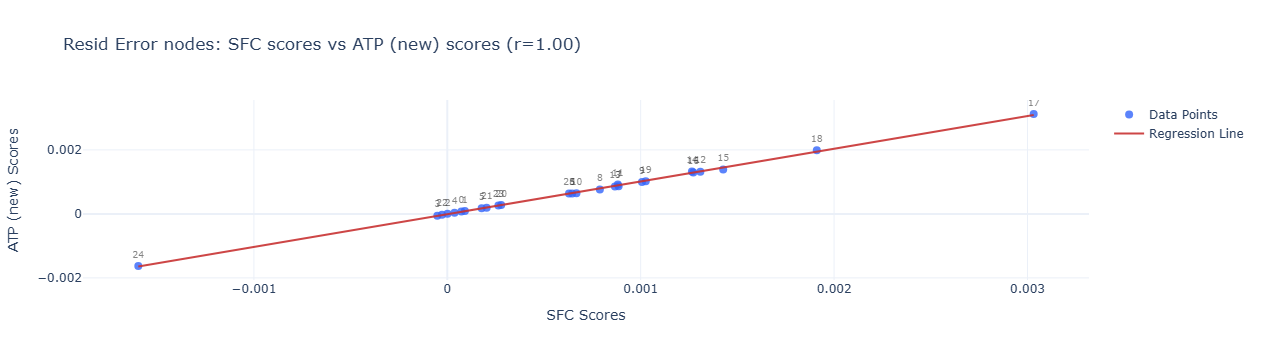

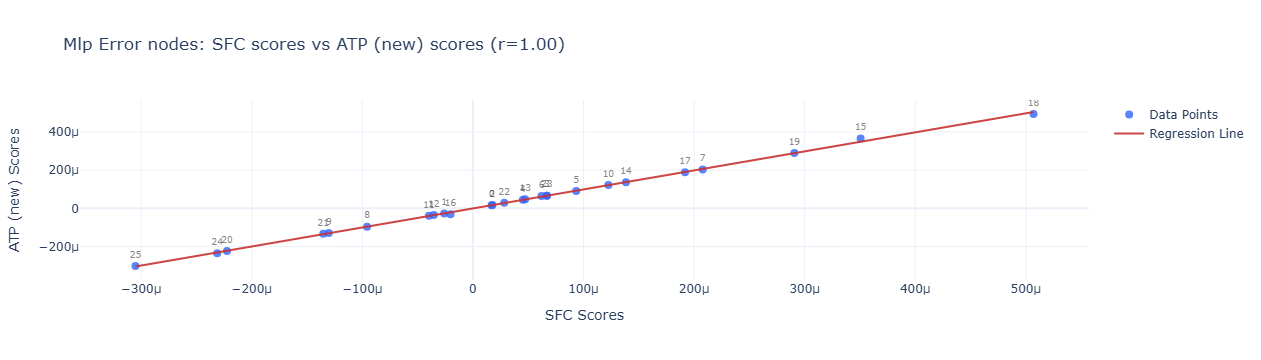

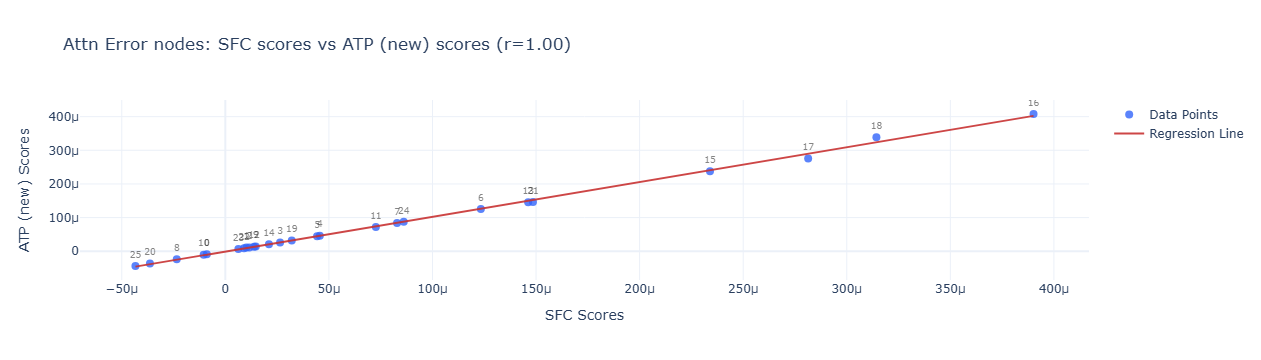

In [20]:
# Compare scores averaged over all positions
compare_sfc_scores(resid_sfc_scores, mlp_sfc_scores, attn_sfc_scores, atp_scores)

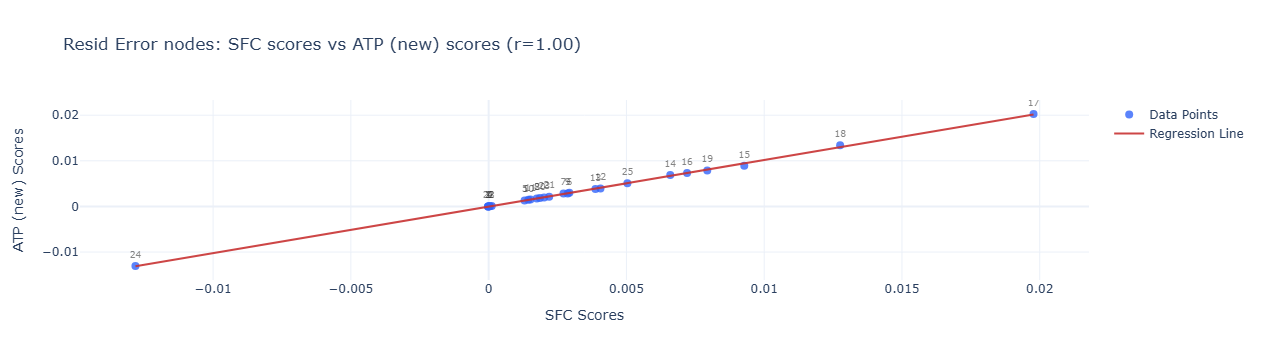

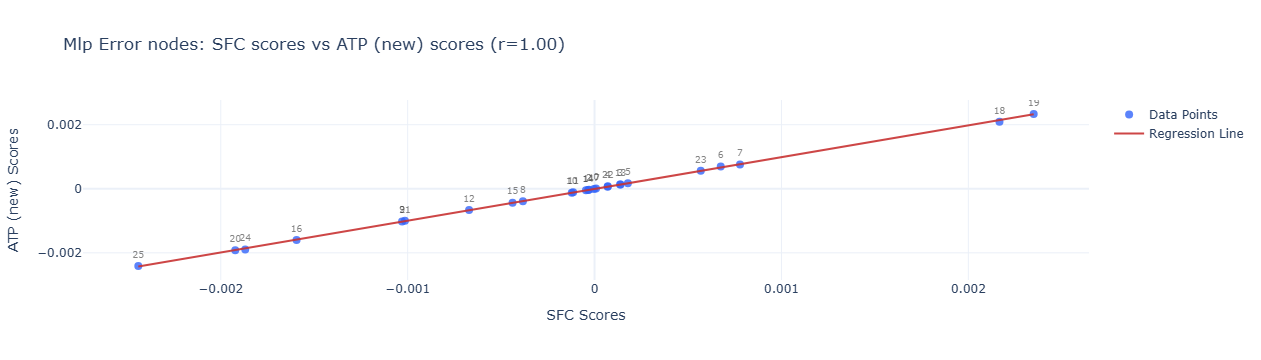

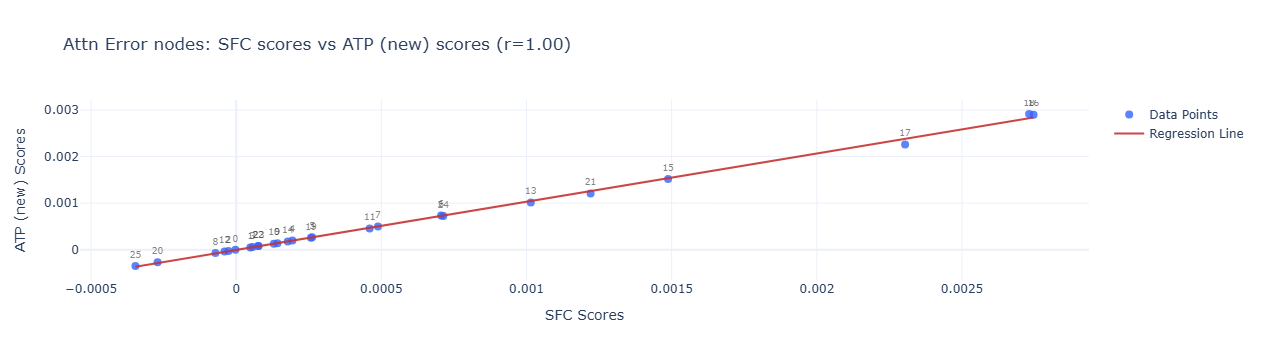

In [21]:
compare_sfc_scores(resid_sfc_scores, mlp_sfc_scores, attn_sfc_scores, atp_scores, position=-2)

The new scores perfectly agree with the old ones, so we did everything correctly

As motivated in ReadME, here we'll produce the **Activation difference norms vs. gradient norms scatter plot** (colored by AtP score) for each error node type (resid/mlp/attn)

In [22]:
def compute_cosine_similarity(activation_diff_norms, gradient_norms, atp_scores, epsilon=1e-8):
    """
    Computes cosine similarity between activation differences and gradients,
    with safeguards against division by zero.
    
    Args:
        activation_diff_norms, gradient_norms, atp_scores: Dictionaries with keys 'resid', 'mlp', 'attn'
            and values as 2D tensors [layer, pos]
        epsilon: Small constant to add to denominators to prevent division by zero
    
    Returns:
        Dictionary with cosine similarities for each node type
    """
    # Initialize cosine similarity dictionary
    cosine_sim = {}
    
    for node_type in ['resid', 'mlp', 'attn']:
        # Add a small epsilon to prevent division by zero
        denominator = activation_diff_norms[node_type] * gradient_norms[node_type] + epsilon
        
        # Cosine similarity = dot product / (norm1 * norm2)
        cosine_sim[node_type] = atp_scores[node_type] / denominator
        
        # Clip values to be in [-1, 1] range (legitimate cosine similarity range)
        cosine_sim[node_type] = torch.clamp(cosine_sim[node_type], -1.0, 1.0)
    
    return cosine_sim


def plot_error_metrics_relation(x_metric, y_metric, color_metric, x_name, y_name, color_name,
                               position=None, n_layers=None):
    """
    Creates a generalized scatter plot showing the relationship between any two error metrics,
    colored by a third metric.
    
    Args:
        x_metric, y_metric, color_metric: Dictionaries with keys 'resid', 'mlp', 'attn'
            and values as 2D tensors [layer, pos]
        x_name, y_name, color_name: Names of the metrics for labels
        position: Integer or None. If None, average over all positions. If int, use that position.
        n_layers: Integer or None. Number of layers to use. If None, use all available.
    """
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    node_types = ['resid', 'mlp', 'attn']
    
    # Create subplots - 3 rows, 1 column
    fig = make_subplots(rows=3, cols=1, 
                        subplot_titles=[f"{node_type.capitalize()} Error Nodes" for node_type in node_types],
                        vertical_spacing=0.1)
    
    for i, node_type in enumerate(node_types):
        row = i + 1
        
        # Determine layers to use
        if n_layers is None:
            n_layers = x_metric[node_type].shape[0]
            
        # Extract data based on position parameter
        if position is None:
            # Average over all positions
            x_vals = x_metric[node_type][:n_layers].float().mean(dim=1).cpu().numpy()
            y_vals = y_metric[node_type][:n_layers].float().mean(dim=1).cpu().numpy()
            color_vals = color_metric[node_type][:n_layers].float().mean(dim=1).cpu().numpy()
            title_suffix = "averaged over all positions"
        else:
            # Use specific position
            x_vals = x_metric[node_type][:n_layers, position].float().cpu().numpy()
            y_vals = y_metric[node_type][:n_layers, position].float().cpu().numpy()
            color_vals = color_metric[node_type][:n_layers, position].float().cpu().numpy()
            title_suffix = f"at position {position}"
            
        # Create hover text showing layer information
        hover_text = [f"Layer: {layer}<br>{x_name}: {x_vals[layer]:.4f}<br>{y_name}: {y_vals[layer]:.4f}<br>{color_name}: {color_vals[layer]:.4f}" 
                     for layer in range(len(x_vals))]
        
        # Create layer labels
        layer_labels = [str(layer) for layer in range(len(x_vals))]
        
        # Add scatter plot with markers
        fig.add_trace(
            go.Scatter(
                x=x_vals,
                y=y_vals,
                mode='markers',
                marker=dict(
                    size=10,
                    color=color_vals,  # Color by specified metric
                    colorscale='Portland',  # More contrastive color scale
                    colorbar=dict(title=color_name) if row == 1 else None,  # Only show colorbar for first plot
                    showscale=(row == 1),  # Only show colorscale for first plot
                ),
                text=hover_text,
                hoverinfo='text',
                name=f'{node_type} markers'
            ),
            row=row, col=1
        )
        
        # Add text labels for layer numbers with larger font and higher position
        fig.add_trace(
            go.Scatter(
                x=x_vals,
                y=y_vals,
                mode='text',
                text=layer_labels,
                textposition='top center',
                textfont=dict(
                    color='rgba(50, 50, 50, 0.7)',  # Slightly more opaque
                    size=11  # Increased font size from 9 to 11
                ),
                # Offset the text position to appear higher above the points
                textpositionsrc='top center',
                dy=-10,  # Move labels higher above the points
                hoverinfo='none',
                showlegend=False
            ),
            row=row, col=1
        )
        
        # Update axes
        fig.update_xaxes(title_text=x_name, row=row, col=1)
        fig.update_yaxes(title_text=y_name, row=row, col=1)
    
    # Update layout
    title = f"Error Node Metrics {title_suffix}"
    fig.update_layout(
        height=900,  # Increased height for 3 stacked plots
        title=title,
        template='plotly_white',
        showlegend=False
    )
    
    fig.show()


# Example usage for the original plot
def plot_activation_diff_vs_gradient(activation_diff_norms, gradient_norms, atp_scores, position=None, n_layers=None):
    plot_error_metrics_relation(
        activation_diff_norms, gradient_norms, atp_scores,
        "Activation Difference Norm", "Gradient Norm", "ATP Score",
        position, n_layers
    )

# Example usage for the cosine similarity plot  
def plot_activation_diff_vs_cosine(activation_diff_norms, gradient_norms, atp_scores, position=None, n_layers=None):
    # Compute cosine similarity between activation differences and gradients
    cosine_sim = compute_cosine_similarity(activation_diff_norms, gradient_norms, atp_scores)
    
    plot_error_metrics_relation(
        activation_diff_norms, cosine_sim, atp_scores,
        "Activation Difference Norm", "Cosine Similarity to Gradient", "ATP Score",
        position, n_layers
    )

### Main result: are gradient & activation norms predictive of the resulting AtP score?

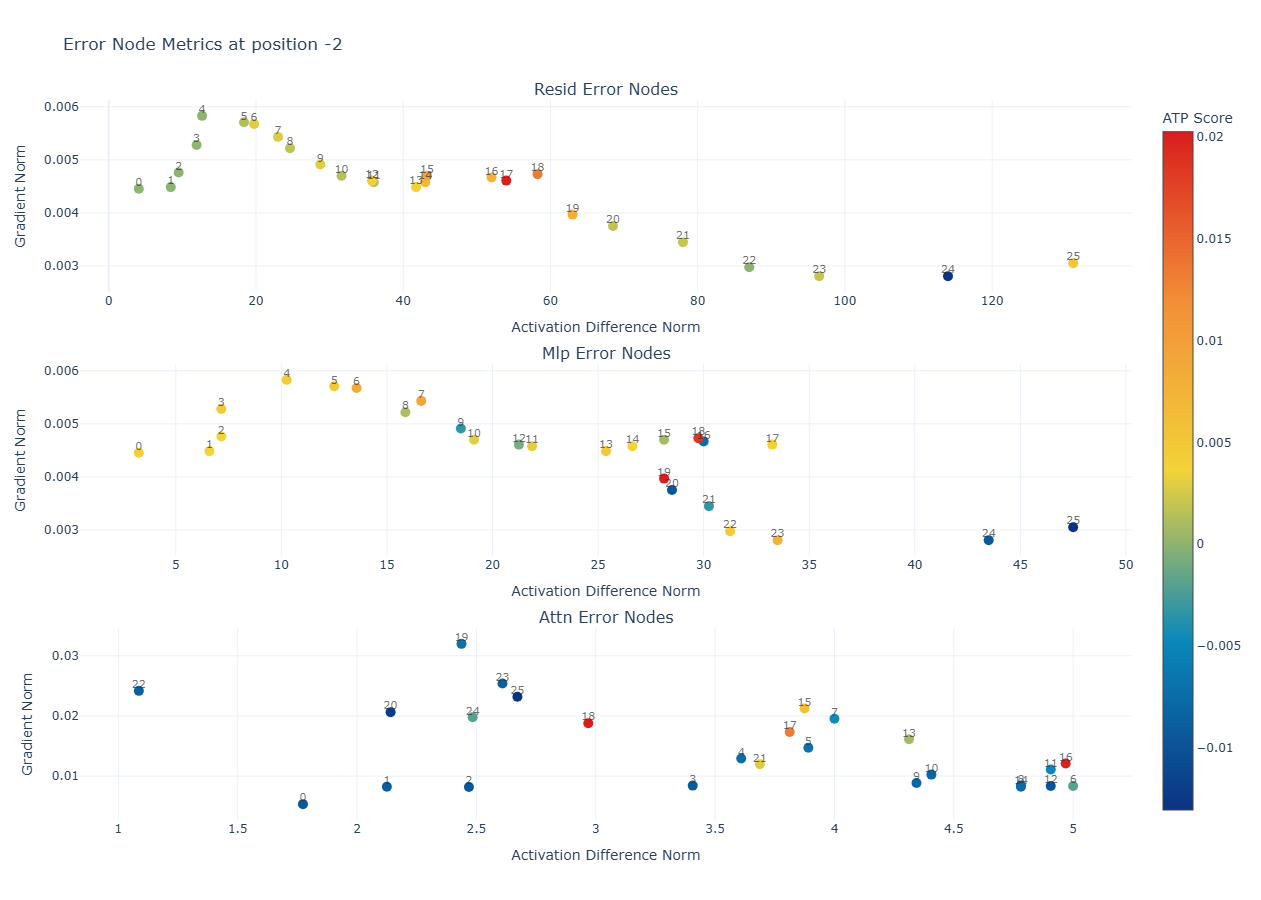

In [23]:
# Plot the error nodes at the last token position (-2 because of the padding)
plot_activation_diff_vs_gradient(activation_diff_norms, gradient_norms, atp_scores, position=-2)

Wow, so at least two things are surprising for me here. I'll separate my description for resid/mlp/attn nodes.

**Resid nodes**:
- Activation difference seems perfectly correlated with the layer number: the greater is the layer of the error node, the more it differs (in norm) between the clean and patched settings
- Activation difference has an interesting non-linear relationship with the AtP scores: **the AtP scores are the greatest when the Activation difference is in its middle values** (not too high & not too low)

**MLP nodes**:
- Activation difference is still perfectly correlated with the layer number, but **it's not longer** that predictive of the error score

**Attention nodes**:
- This is just random essentially :D 
- The only takeaway I have is that the gradients here are much higher in norm than in the previous cases, and the activation difference on the other hand is much lower. But neither is predictive of anything.

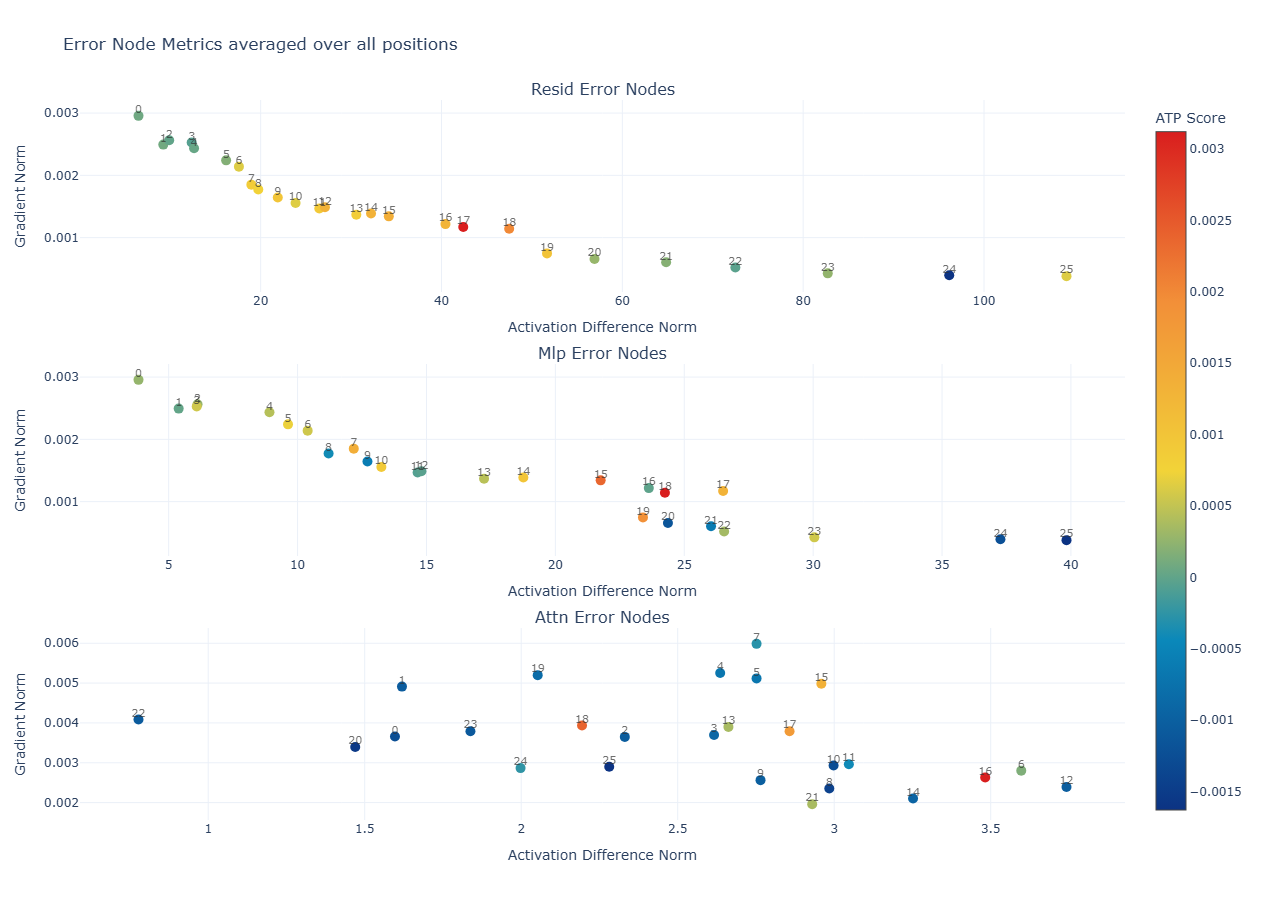

In [24]:
# Plot the mean error nodes (averaged over all token positions)
plot_activation_diff_vs_gradient(activation_diff_norms, gradient_norms, atp_scores)

This is just a smoothed-out version of the previous plot due to scores averaging across positions.

### Sanity check #1: does the alignment with the gradient even matter?

Here I'll plot activation diff norm vs cosine_sim(activation_dif, gradient) for error nodes, where scores are averaged over token positions.
The question in the heading is a bit naive (because if cosine sim didn't matter, the AtP score would be linearly correlated with norm(activation_dif) or norm(gradient), but this is not the case based on the above plot), but I just wanted to check anyway

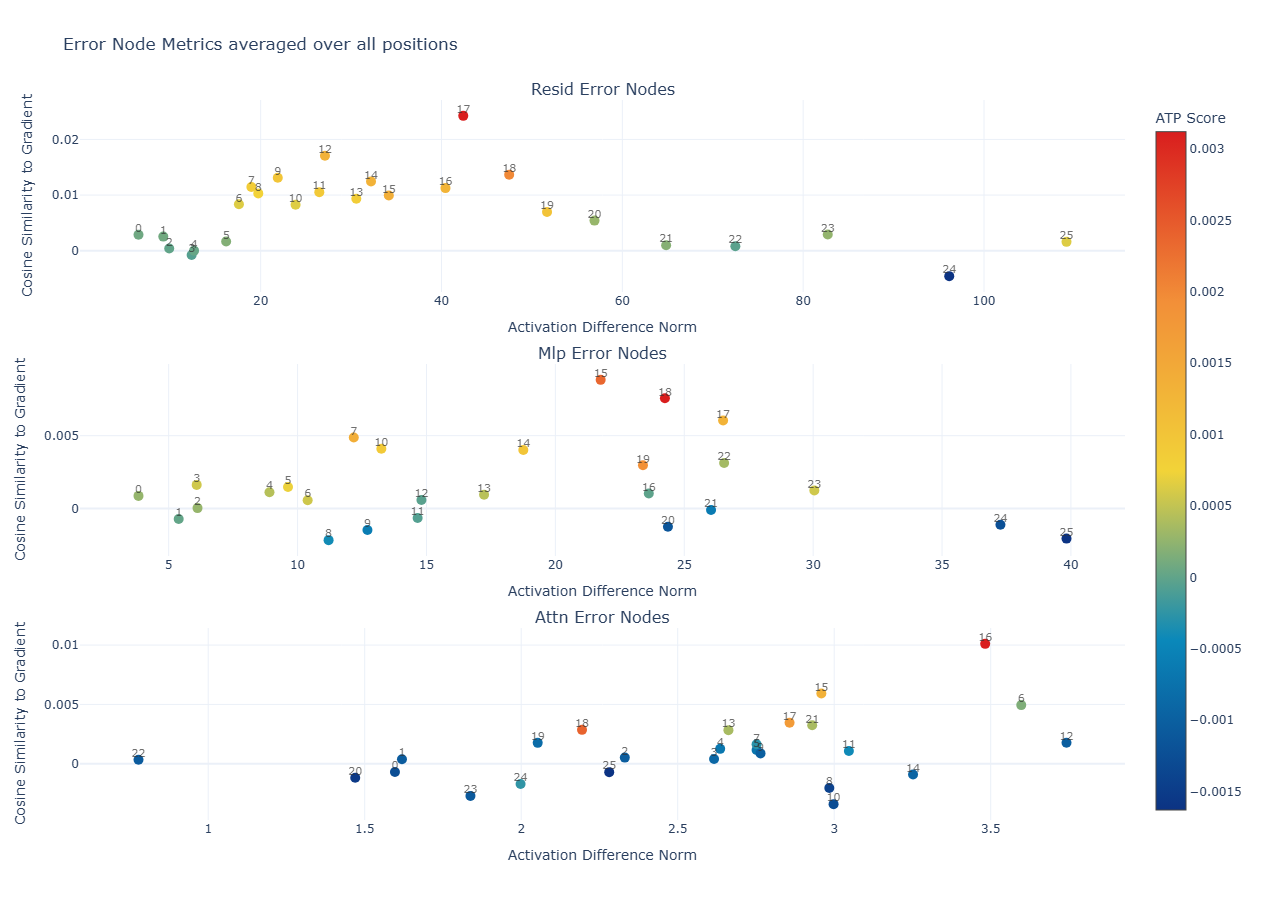

In [25]:
plot_activation_diff_vs_cosine(activation_diff_norms, gradient_norms, atp_scores)

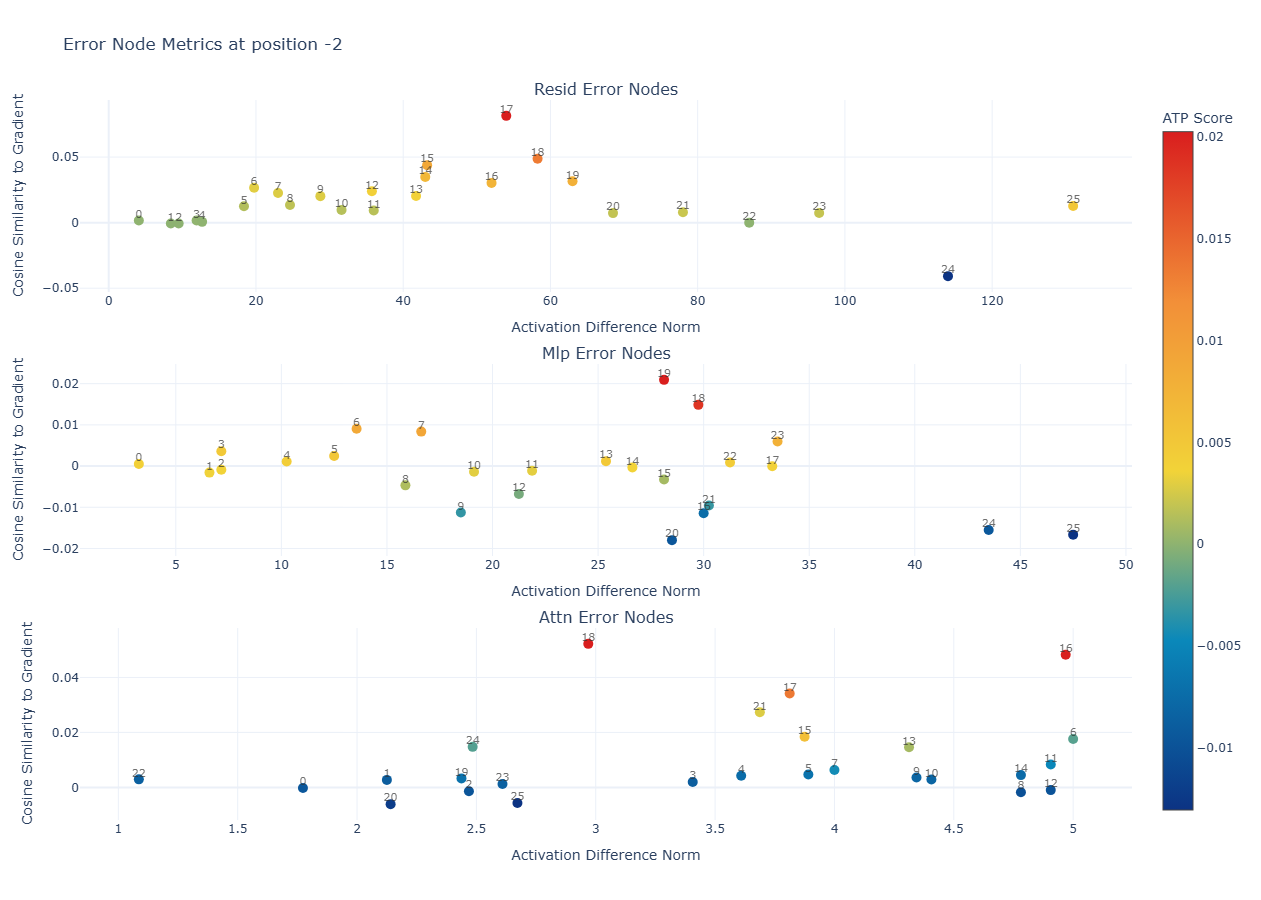

In [26]:
# Plot activation diff norm vs cosine_sim(activation_dif, gradient) for error nodes, where scores are taken at the last token position
plot_activation_diff_vs_cosine(activation_diff_norms, gradient_norms, atp_scores, position=-2)

### Sanity check #2: is this behavior unique to error nodes?

**Question**: will we see the same patterns if we take resid_post activations instead of the error nodes?
- The gradients should be the same (mathematically they are)
- But norm(activation_diff) is not guaranteed to in the same way

Let's load the corresponding resid metrics and figure this out

In [27]:
def load_resid_metrics(dataset_name='sva'):
    metric_names = ['activation_diff', 'gradient', 'atp_score']
    loaded_metrics = {}
    
    for metric_name in metric_names:
        filename = f'{dataset_name}_resid_{metric_name}.pkl'
        filepath = datapath / filename
        
        print(f'Loading {filename}...')
        loaded_metrics[metric_name] = torch.load(filepath)
    
    return (
        loaded_metrics['activation_diff'],
        loaded_metrics['gradient'],
        loaded_metrics['atp_score']
    )

activation_diff_norms, gradient_norms, atp_scores = load_resid_metrics()

Loading sva_resid_activation_diff.pkl...
Loading sva_resid_gradient.pkl...
Loading sva_resid_atp_score.pkl...


In [28]:
activation_diff_norms.shape, gradient_norms.shape, atp_scores.shape

(torch.Size([26, 8]), torch.Size([26, 8]), torch.Size([26, 8]))

In [29]:
def plot_resid_metrics_relation(activation_diff_norms, gradient_norms, atp_scores, x_name, y_name, color_name,
                               position=None, n_layers=None):
    """
    Creates a scatter plot showing the relationship between two residual metrics,
    colored by a third metric.
    
    Args:
        activation_diff_norms, gradient_norms, atp_scores: Tensors of shape [n_layers, seq_len]
        x_name, y_name, color_name: Names of the metrics for labels
        position: Integer or None. If None, average over all positions. If int, use that position.
        n_layers: Integer or None. Number of layers to use. If None, use all available.
    """
    import plotly.graph_objects as go
    
    # Determine layers to use
    if n_layers is None:
        n_layers = activation_diff_norms.shape[0]
    
    # Extract data based on position parameter
    if position is None:
        # Average over all positions
        x_vals = activation_diff_norms[:n_layers].float().mean(dim=1).cpu().numpy()
        y_vals = gradient_norms[:n_layers].float().mean(dim=1).cpu().numpy()
        color_vals = atp_scores[:n_layers].float().mean(dim=1).cpu().numpy()
        title_suffix = "averaged over all positions"
    else:
        # Use specific position
        x_vals = activation_diff_norms[:n_layers, position].float().cpu().numpy()
        y_vals = gradient_norms[:n_layers, position].float().cpu().numpy()
        color_vals = atp_scores[:n_layers, position].float().cpu().numpy()
        title_suffix = f"at position {position}"
    
    # Create hover text showing layer information
    hover_text = [f"Layer: {layer}<br>{x_name}: {x_vals[layer]:.4f}<br>{y_name}: {y_vals[layer]:.4f}<br>{color_name}: {color_vals[layer]:.4f}" 
                 for layer in range(len(x_vals))]
    
    # Create layer labels
    layer_labels = [str(layer) for layer in range(len(x_vals))]
    
    # Create the figure
    fig = go.Figure()
    
    # Add scatter plot with markers
    fig.add_trace(
        go.Scatter(
            x=x_vals,
            y=y_vals,
            mode='markers',
            marker=dict(
                size=10,
                color=color_vals,  # Color by specified metric
                colorscale='Portland',  # More contrastive color scale
                colorbar=dict(title=color_name),
            ),
            text=hover_text,
            hoverinfo='text',
        )
    )
    
    # Add text labels for layer numbers
    fig.add_trace(
        go.Scatter(
            x=x_vals,
            y=y_vals,
            mode='text',
            text=layer_labels,
            textposition='top center',
            textfont=dict(
                color='rgba(50, 50, 50, 0.7)',
                size=11
            ),
            dy=-10,  # Move labels higher above the points
            hoverinfo='none',
            showlegend=False
        )
    )
    
    # Update layout
    title = f"Residual Activation Metrics {title_suffix}"
    fig.update_layout(
        title=title,
        xaxis_title=x_name,
        yaxis_title=y_name,
        template='plotly_white',
        showlegend=False
    )
    
    fig.show()

# Compute cosine similarity for residual activations
def compute_resid_cosine_similarity(activation_diff_norms, gradient_norms, atp_scores, epsilon=1e-8):
    """
    Computes cosine similarity between activation differences and gradients for residual activations.
    
    Args:
        activation_diff_norms, gradient_norms, atp_scores: Tensors of shape [n_layers, seq_len]
        epsilon: Small constant to prevent division by zero
    
    Returns:
        Tensor with cosine similarities
    """
    # Add a small epsilon to prevent division by zero
    denominator = activation_diff_norms * gradient_norms + epsilon
    
    # Cosine similarity = dot product / (norm1 * norm2)
    cosine_sim = atp_scores / denominator
    
    # Clip values to be in [-1, 1] range
    cosine_sim = torch.clamp(cosine_sim, -1.0, 1.0)
    
    return cosine_sim

# Convenience functions for specific plots
def plot_resid_act_vs_grad(activation_diff_norms, gradient_norms, atp_scores, position=None, n_layers=None):
    plot_resid_metrics_relation(
        activation_diff_norms, gradient_norms, atp_scores,
        "Activation Difference Norm", "Gradient Norm", "ATP Score",
        position, n_layers
    )

def plot_resid_act_vs_cosine(activation_diff_norms, gradient_norms, atp_scores, position=None, n_layers=None):
    # Compute cosine similarity 
    cosine_sim = compute_resid_cosine_similarity(activation_diff_norms, gradient_norms, atp_scores)
    
    plot_resid_metrics_relation(
        activation_diff_norms, cosine_sim, atp_scores,
        "Activation Difference Norm", "Cosine Similarity to Gradient", "ATP Score",
        position, n_layers
    )

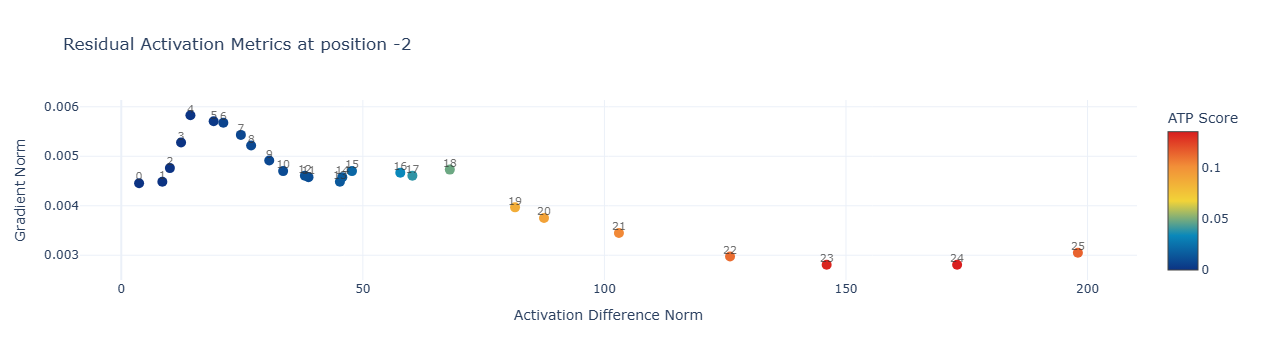

In [30]:
# Plot activation diff norm vs gradient norm for resid_post activation at the last token position
plot_resid_act_vs_grad(activation_diff_norms, gradient_norms, atp_scores, position=-2)

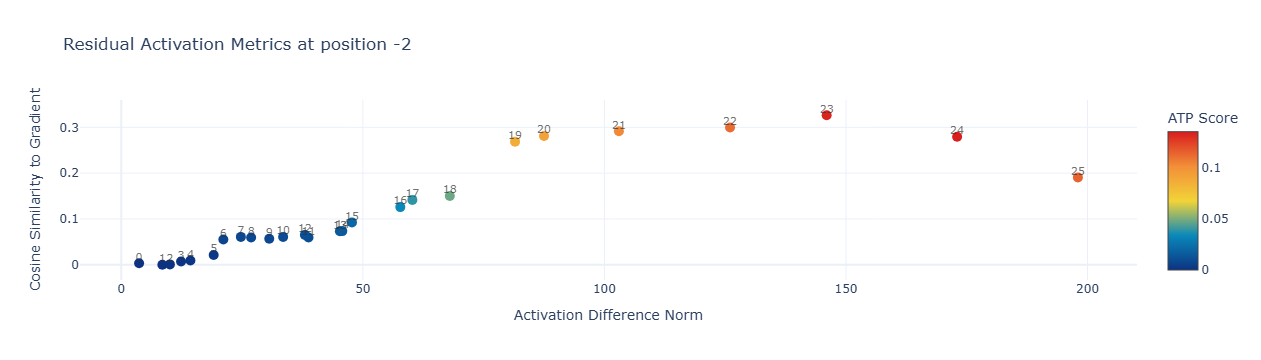

In [31]:
# Plot activation diff norm vs cosine_sim(activation_dif, gradient) for resid_post activation at the last token position
plot_resid_act_vs_cosine(activation_diff_norms, gradient_norms, atp_scores, position=-2)

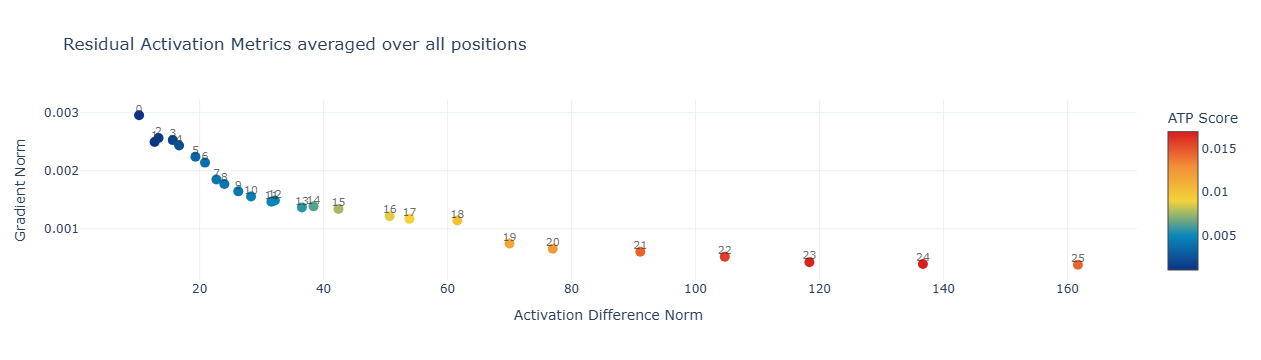

In [32]:
# Plot activation diff norm vs gradient norm for resid_post activation, averaged over all token positions
plot_resid_act_vs_grad(activation_diff_norms, gradient_norms, atp_scores)